# Лабораторная работа №2: NER – Named Entity Recognition

# 1. Загрузка датасета и обзор

In [1]:
!pip install datasets

from datasets import load_dataset

ds = load_dataset("Mykes/patient_queries_ner")

print(f"Информация о датасете:\n")
print(ds)

for split in ['train', 'validation', 'test']:
    print(f"\nНабор данных {split}:")
    print(f"Количество строк: {len(ds[split])}")
    print(f"Особенности: {ds[split].features}")

    for example in ds[split].select(range(5)):
        query = example['query']
        merged_ner = example['merged_ner']
        print(f"Запрос: {query}\nОбъединённые метки NER: {merged_ner}\n")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Информация о датасете:

DatasetDict({
    train: Dataset({
        features: ['query', 'merged_ner'],
        num_rows: 4286
    })
    validation: Dataset({
        features: ['query', 'merged_ner'],
        num_rows: 238
    })
    test: Dataset({
        features: ['query', 'merged_ner'],
        num_rows: 239
    })
})

Набор данных train:
Количество строк: 4286
Особенности: {'query': Value(dtype='string', id=None), 'merged_ner': Value(dtype='string', id=None)}
Запрос: у моей дочери начались кровянистые выделения, ей 12 лет. что это может быть и к какому врачу нам обратиться?
Объединённые метки NER: O,O,O,O,B-SIM,I-SIM,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O

Запрос: у моего ребенка появились перхоть и зуд на голове, что это может быть и как с этим бороться?
Объединённые метки NER: O,O,CHILD,O,B-SIM,O,B-SIM,I-SIM,I-SIM,O,O,O,O,O,O,O,O,O,O,O

Запрос: у меня появились тянущие боли внизу живота и выделения с неприятным запахом. что это может быть и к какому врачу мне обратиться?
Объединённые 

Проанализируем датасет:

1. Структура датасета:
Датасет состоит из трех разделов: train, validation и test.
Каждый раздел содержит два признака:
query: текстовый запрос, содержащий вопросы или описания симптомов.
merged_ner: метки именованных сущностей (NER), где каждое слово в запросе помечено одной из меток (например, B-SIM, I-SIM, O).

2. Размеры разделов:
Train: 4286 записей.
Validation: 238 записей.
Test: 239 записей.

3. Признаки:
query: текстовые строки, в которых пользователи описывают симптомы, заболевания или задают вопросы о медицинской помощи.
merged_ner: метки для каждой сущности в тексте, где:
B-SIM и I-SIM: обозначают начало и продолжение симтома.
B-SPEC и I-SPEC: обозначают начало и продолжение специфической сущности (например, специалист).
O: означает отсутствие метки для данного слова.

Таким образом для нашей задачи необходимо будет извлечь и классифицировать различные медицинские сущности из текстовых запросов.

# 2. EDA: Распределение меток NER

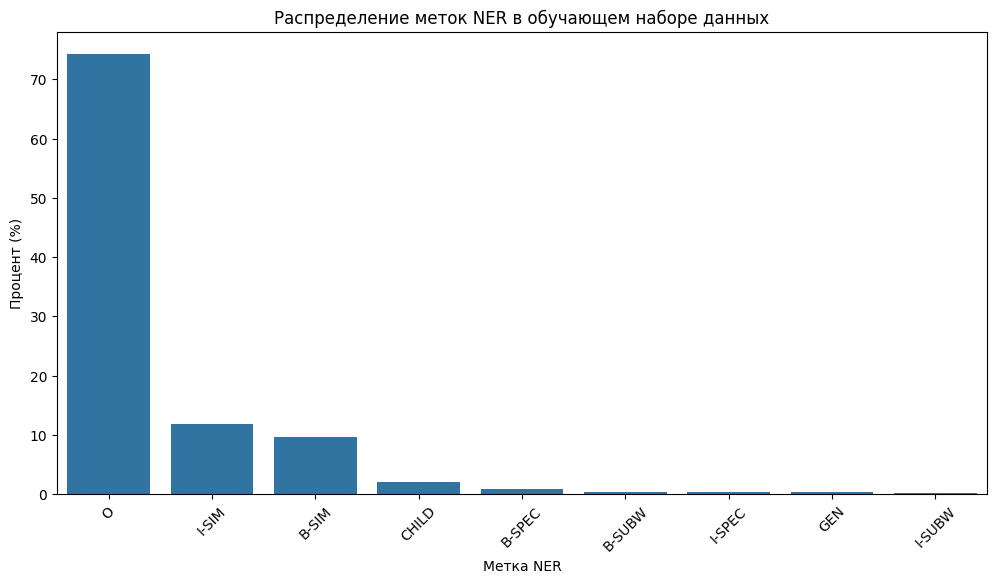

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_ner = ds['train']['merged_ner']
train_ner_flat = [label for row in train_ner for label in row.split(',')]

ner_labels_count = pd.Series(train_ner_flat).value_counts(normalize=True) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=ner_labels_count.index, y=ner_labels_count.values)
plt.title("Распределение меток NER в обучающем наборе данных")
plt.xlabel("Метка NER")
plt.ylabel("Процент (%)")
plt.xticks(rotation=45)
plt.show()

# 3. EDA: Длина запросов

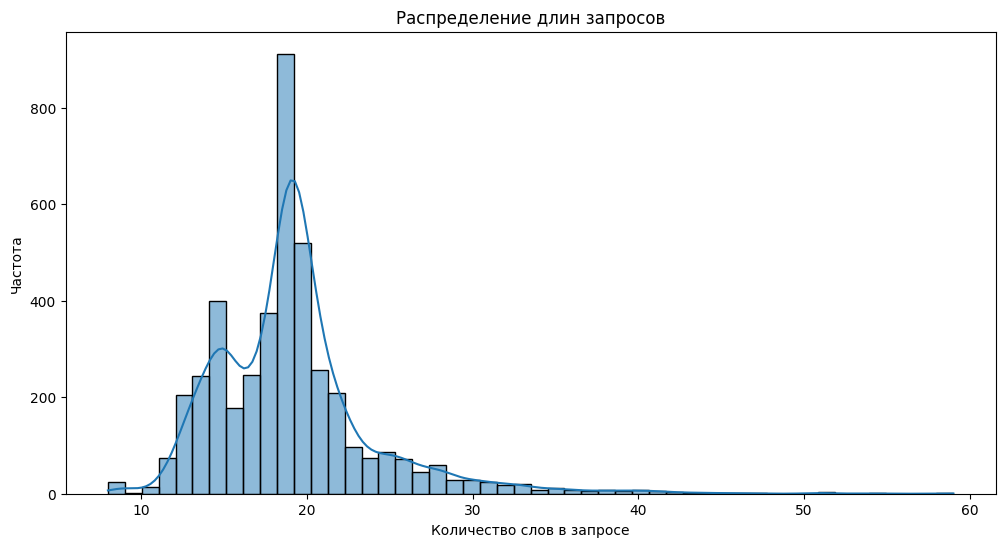

In [3]:
query_lengths = [len(query.split()) for query in ds['train']['query']]

plt.figure(figsize=(12, 6))
sns.histplot(query_lengths, bins=50, kde=True)
plt.title("Распределение длин запросов")
plt.xlabel("Количество слов в запросе")
plt.ylabel("Частота")
plt.show()

# 4. EDA: Количество сущностей на запрос

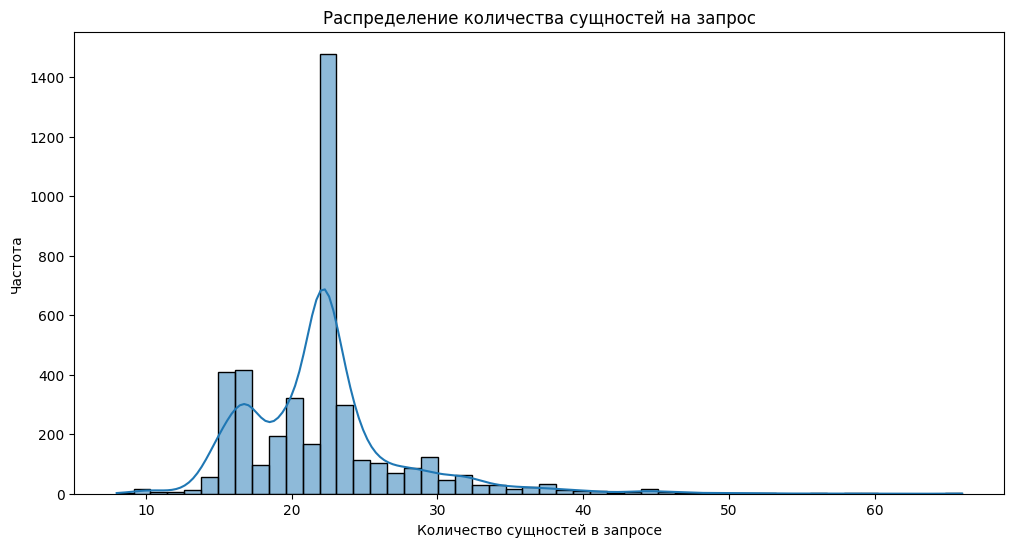

In [4]:
entity_counts = [len(ner.split(',')) for ner in ds['train']['merged_ner']]

plt.figure(figsize=(12, 6))
sns.histplot(entity_counts, bins=50, kde=True)
plt.title("Распределение количества сущностей на запрос")
plt.xlabel("Количество сущностей в запросе")
plt.ylabel("Частота")
plt.show()

# 5. EDA: Корреляция между длиной запроса и количеством сущностей

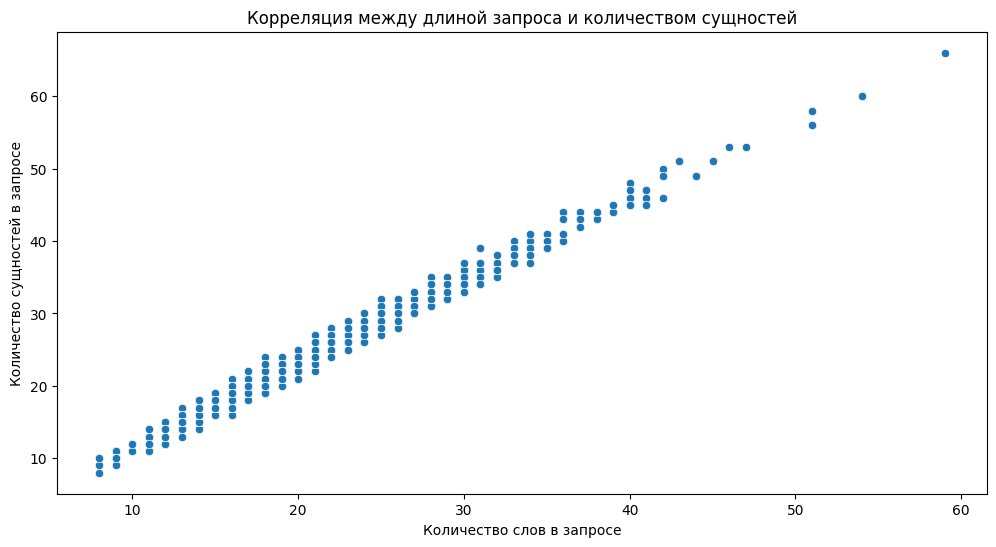

In [5]:
entity_counts = [len(ner.split(',')) for ner in ds['train']['merged_ner']]

plt.figure(figsize=(12, 6))
sns.scatterplot(x=query_lengths, y=entity_counts)
plt.title("Корреляция между длиной запроса и количеством сущностей")
plt.xlabel("Количество слов в запросе")
plt.ylabel("Количество сущностей в запросе")
plt.show()

# 6. EDA: Частота слов в запросах (исключая стоп-слова)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


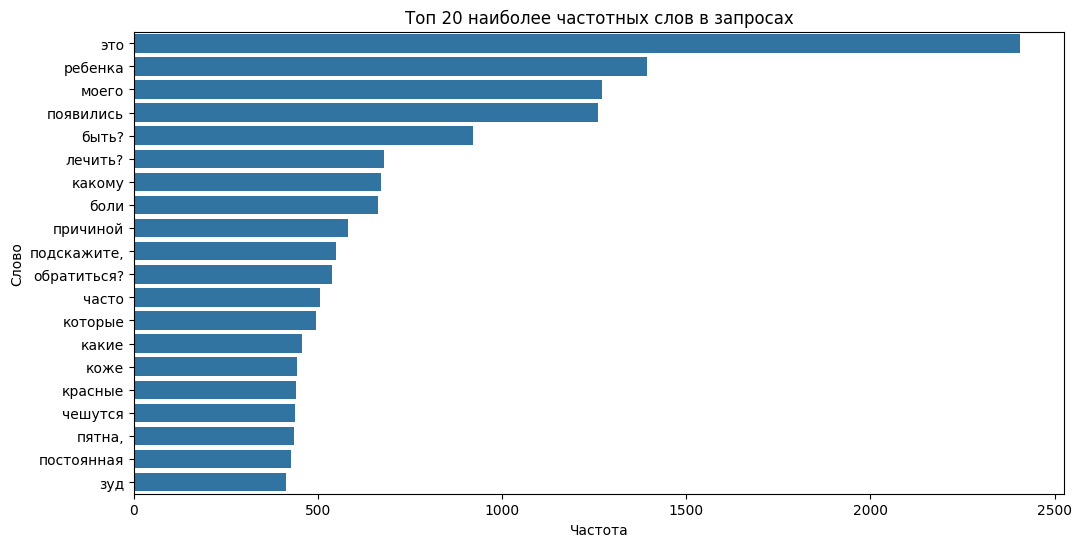

In [6]:
import nltk
from collections import Counter
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

all_words = [word for query in ds['train']['query'] for word in query.split() if word not in stop_words]

word_freq = Counter(all_words)

top_words = word_freq.most_common(20)

top_words_df = pd.DataFrame(top_words, columns=["Слово", "Частота"])

plt.figure(figsize=(12, 6))
sns.barplot(x='Частота', y='Слово', data=top_words_df)
plt.title("Топ 20 наиболее частотных слов в запросах")
plt.xlabel("Частота")
plt.ylabel("Слово")
plt.show()

# 7. EDA: Частота сущностей по типам NER

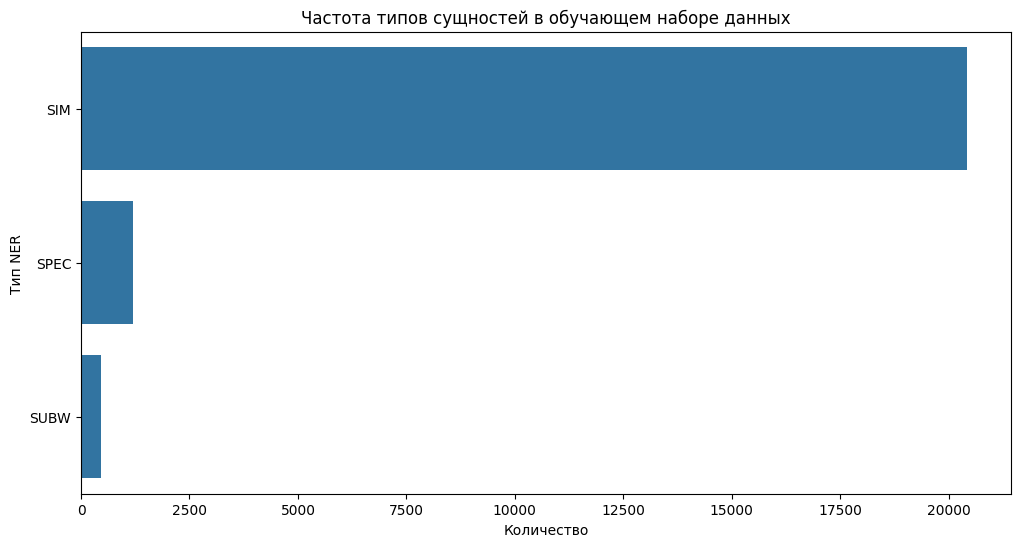

In [7]:
ner_types = [
    label.split('-')[1]
    for label in train_ner_flat
    if label != 'O' and '-' in label
]

plt.figure(figsize=(12, 6))
sns.countplot(y=ner_types, order=pd.Series(ner_types).value_counts().index)
plt.title("Частота типов сущностей в обучающем наборе данных")
plt.xlabel("Количество")
plt.ylabel("Тип NER")
plt.show()

# 8. EDA: Количество уникальных сущностей на запрос

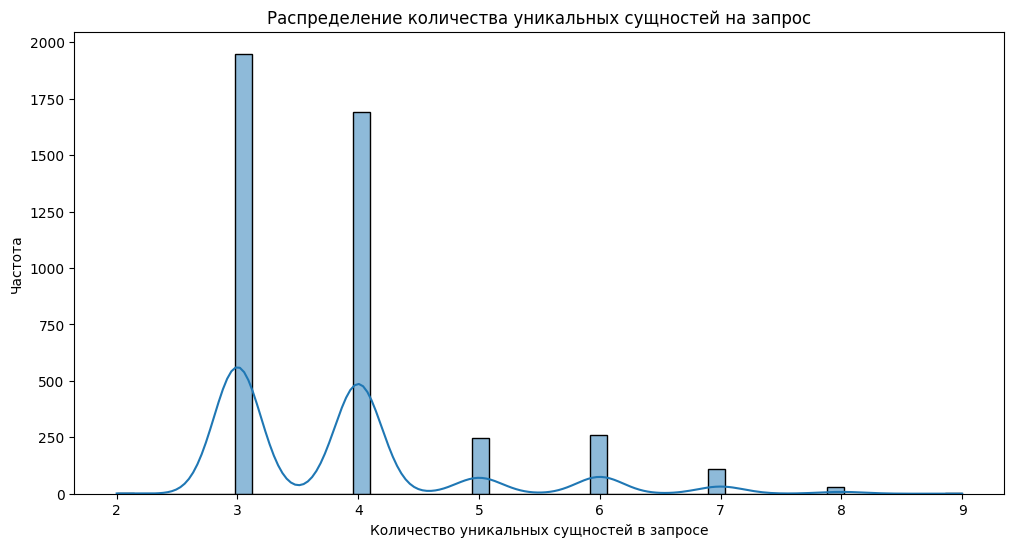

In [8]:
unique_entity_counts = [len(set(ner.split(','))) for ner in ds['train']['merged_ner']]

plt.figure(figsize=(12, 6))
sns.histplot(unique_entity_counts, bins=50, kde=True)
plt.title("Распределение количества уникальных сущностей на запрос")
plt.xlabel("Количество уникальных сущностей в запросе")
plt.ylabel("Частота")
plt.show()

# 9. EDA: Распределение меток NER по различным датасетам (train, validation, test)

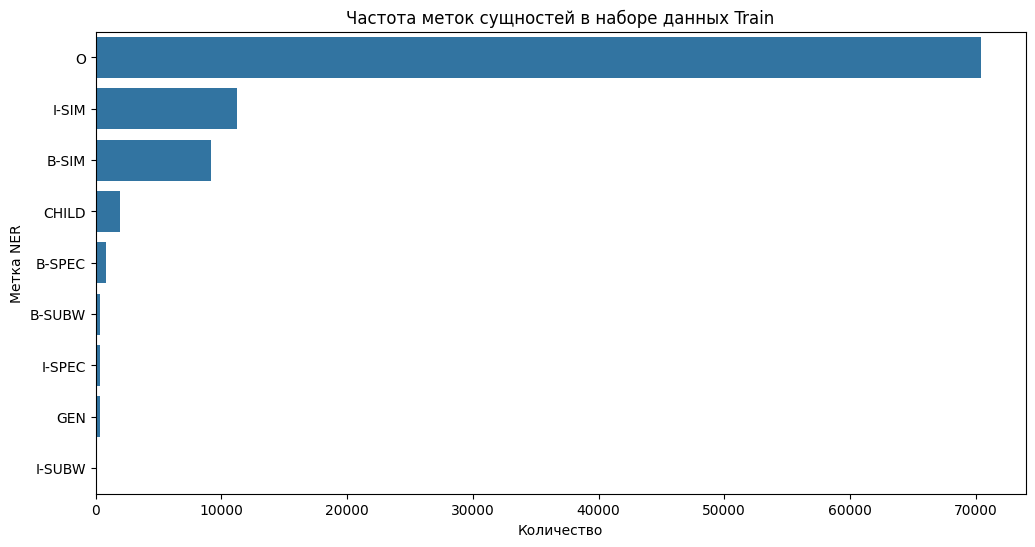

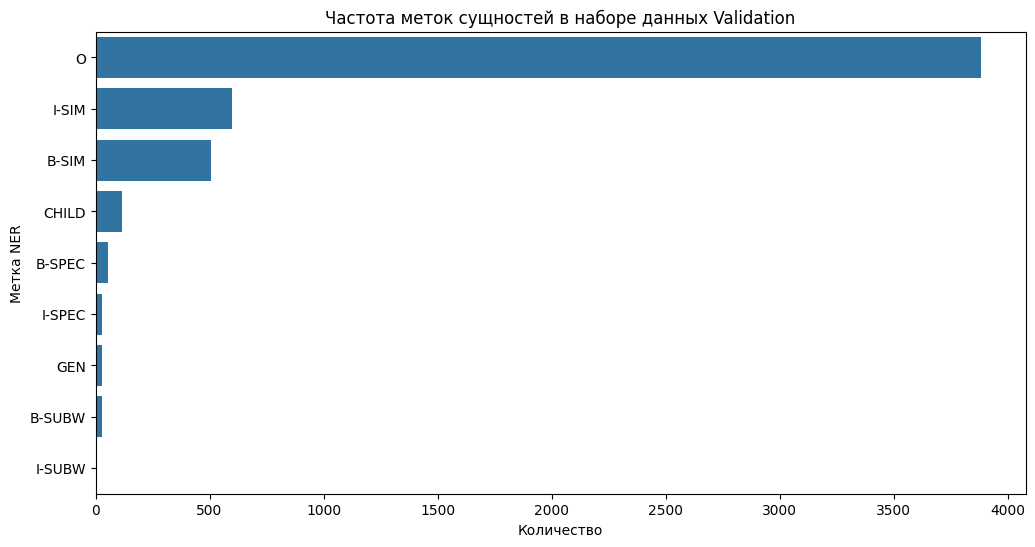

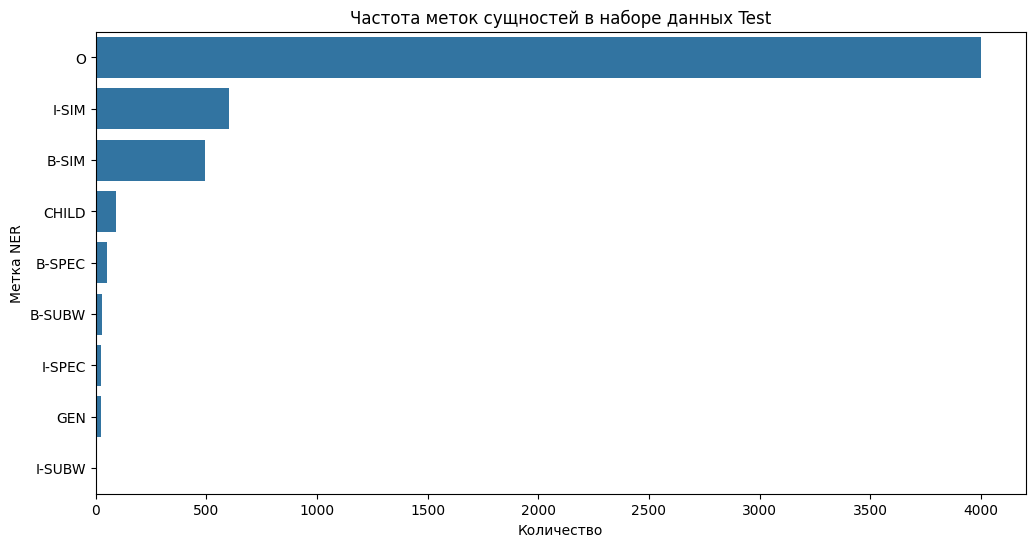

In [9]:
splits = ['train', 'validation', 'test']
for split in splits:
    ner_labels = [label for row in ds[split]['merged_ner'] for label in row.split(',')]

    plt.figure(figsize=(12, 6))
    sns.countplot(y=ner_labels, order=pd.Series(ner_labels).value_counts().index)
    plt.title(f"Частота меток сущностей в наборе данных {split.capitalize()}")
    plt.xlabel("Количество")
    plt.ylabel("Метка NER")
    plt.show()

# 10. Проверка данных

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

valid_labels = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]

def check_dataset_structure(ds):
    print("Проверка структуры датасета...")
    for split in ['train', 'validation', 'test']:
        if split in ds:
            print(f"Сплит {split}:")
            print(f"- Признаки: {list(ds[split].features.keys())}")
            print(f"- Количество записей: {len(ds[split])}")
        else:
            print(f"{split} сплит отсутствует в датасете!")

def check_empty_queries(ds):
    print("\nПроверка пустых запросов...")
    empty_queries = []
    for split in ['train', 'validation', 'test']:
        if split in ds:
            for i, example in enumerate(ds[split]):
                if not example['query'].strip():
                    empty_queries.append((split, i))
    if empty_queries:
        print(f"Найдены пустые запросы: {len(empty_queries)}")
        for query in empty_queries[:5]:
            print(f"Сплит: {query[0]}, Индекс: {query[1]}")
    else:
        print("Пустые запросы не найдены.")

def check_token_label_consistency(ds, tokenizer):
    print("\nПроверка на несоответствие токенов и меток...")
    inconsistent_count = 0
    for split in ['train', 'validation', 'test']:
        if split in ds:
            for i, example in enumerate(ds[split]):
                tokens = tokenizer.tokenize(example['query'])
                labels = example['merged_ner'].split(',')
                if len(tokens) != len(labels):
                    if inconsistent_count < 5:
                        print(f"Несоответствие в сплите {split}, Индекс: {i}")
                        print(f"- Tokens ({len(tokens)}): {tokens}")
                        print(f"- Labels ({len(labels)}): {labels}")
                    inconsistent_count += 1
    print(f"Количество несоответствующих примеров: {inconsistent_count}")

def check_valid_labels(ds, valid_labels):
    print("\nПроверка на корректность меток...")
    invalid_labels = []
    for split in ['train', 'validation', 'test']:
        if split in ds:
            for i, example in enumerate(ds[split]):
                labels = example['merged_ner'].split(',')
                for label in labels:
                    if label not in valid_labels:
                        invalid_labels.append((split, i, label))
    if invalid_labels:
        print(f"Найдены некорректные метки: {len(invalid_labels)}")
        for label in invalid_labels[:5]:
            print(f"Сплит: {label[0]}, Индекс: {label[1]}, Некорректная метка: {label[2]}")
    else:
        print("Некорректные метки не найдены.")

def perform_data_checks(ds, tokenizer, valid_labels):
    print("Начинаем проверки данных...")
    check_dataset_structure(ds)
    check_empty_queries(ds)
    check_token_label_consistency(ds, tokenizer)
    check_valid_labels(ds, valid_labels)
    print("Проверки завершены.")

valid_labels = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]
perform_data_checks(ds, tokenizer, valid_labels)

Начинаем проверки данных...
Проверка структуры датасета...
Сплит train:
- Признаки: ['query', 'merged_ner']
- Количество записей: 4286
Сплит validation:
- Признаки: ['query', 'merged_ner']
- Количество записей: 238
Сплит test:
- Признаки: ['query', 'merged_ner']
- Количество записей: 239

Проверка пустых запросов...
Пустые запросы не найдены.

Проверка на несоответствие токенов и меток...
Несоответствие в сплите train, Индекс: 0
- Tokens (87): ['у', 'м', '##о', '##е', '##и', 'д', '##о', '##ч', '##е', '##р', '##и', 'н', '##а', '##ч', '##а', '##л', '##и', '##с', '##ь', 'к', '##р', '##ов', '##я', '##н', '##и', '##с', '##т', '##ы', '##е', 'в', '##ы', '##д', '##е', '##л', '##е', '##н', '##ия', ',', 'е', '##и', '12', 'л', '##е', '##т', '.', 'ч', '##т', '##о', 'э', '##т', '##о', 'м', '##о', '##ж', '##е', '##т', 'б', '##ы', '##т', '##ь', 'и', 'к', 'к', '##а', '##к', '##о', '##м', '##у', 'в', '##р', '##а', '##ч', '##у', 'н', '##а', '##м', 'о', '##б', '##р', '##а', '##т', '##и', '##т', '##ь', '#

# 11. Препроцессинг

In [11]:
import re
import json
from collections import Counter
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def clean_text(text):
    print(f"Очищаем текст: {text}")
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,?!]', '', text)
    cleaned_text = text.strip()
    print(f"Очищенный текст: {cleaned_text}")
    return cleaned_text

def clean_dataset(ds):
    print("Проверка структуры датасета:")
    print(ds)

    for split in ['train', 'validation', 'test']:
        print(f"\nОбработка {split} сплита...")
        if split not in ds:
            print(f"{split} сплит не найден в датасете!")
            continue
        print(f"Пример из {split} сплита: {ds[split][0]}")
        ds[split] = ds[split].map(lambda x: {'query': clean_text(x['query'])})
        print(f"Обработано {len(ds[split])} записей в {split} сплите.")
        print(f"Пример после очистки: {ds[split][0]['query']}")

def simplify_labels(labels):
    print(f"Упрощаем метки: {labels}")
    simplified_labels = [label.split('-')[-1] if '-' in label else label for label in labels]
    print(f"Упрощенные метки: {simplified_labels}")
    return simplified_labels

def correct_labels(tokens, labels):
    if len(tokens) > len(labels):
        labels.extend(['O'] * (len(tokens) - len(labels)))
    elif len(tokens) < len(labels):
        labels = labels[:len(tokens)]
    print(f"Скорректированные метки: {labels}")
    return labels

def filter_invalid_examples(dataset):
    valid_data = []
    invalid_count = 0
    for example in dataset:
        tokens = tokenizer.tokenize(example['query'])
        labels = example['merged_ner'].split(',')
        if len(tokens) != len(labels):
            print(f"Несоответствие: tokens({len(tokens)}) != labels({len(labels)}) для query: {example['query']}")
            labels = correct_labels(tokens, labels)
            invalid_count += 1
        valid_data.append({'tokens': tokens, 'labels': labels})

    print(f"Количество исправленных примеров: {invalid_count}")
    print(f"Всего примеров после фильтрации: {len(valid_data)}")
    return valid_data

def analyze_frequencies(tokens, labels):
    token_freq = Counter([token for tokens_list in tokens for token in tokens_list])
    label_freq = Counter([label for labels_list in labels for label in labels_list])

    print("Топ-10 самых частых токенов:", token_freq.most_common(10))
    print("Топ-10 самых редких токенов:", token_freq.most_common()[:-11:-1])
    print("Распределение меток:", label_freq)

def align_labels_with_subwords(tokens, labels):
    aligned_labels = []
    for token, label in zip(tokens, labels):
        subwords = tokenizer.tokenize(token)
        aligned_labels.extend([label] + ['O'] * (len(subwords) - 1))
    return aligned_labels

def preprocess_dataset(ds):
    print("Начинаем очистку данных...")
    clean_dataset(ds)

    print("Начинаем фильтрацию данных...")
    filtered_train = filter_invalid_examples(ds['train'])

    print("Начинаем анализ частоты...")
    train_tokens = [example['tokens'] for example in filtered_train]
    train_labels = [simplify_labels(example['labels']) for example in filtered_train]
    analyze_frequencies(train_tokens, train_labels)

    print("Начинаем выравнивание меток с подсловами...")
    train_aligned_labels = [
        align_labels_with_subwords(tokens, labels)
        for tokens, labels in zip(train_tokens, train_labels)
    ]

    processed_data = {
        "tokens": train_tokens,
        "labels": train_labels,
        "aligned_labels": train_aligned_labels
    }

    with open("processed_train.json", "w") as f:
        json.dump(processed_data, f)

    print("Препроцессинг завершен и данные сохранены.")

preprocess_dataset(ds)

Выходные данные были обрезаны до нескольких последних строк (5000).
Упрощенные метки: ['O', 'O', 'SIM', 'SIM', 'SIM', 'SIM', 'SIM', 'O', 'SIM', 'O', 'SIM', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Упрощаем метки: ['O', 'O', 'CHILD', 'O', 'O', 'O', 'B-SIM', 'I-SIM', 'O', 'B-SIM', 'B-SIM', 'O', 'B-SIM', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Упрощенные метки: ['O', 'O', 'CHILD', 'O', 'O', 'O', 'SIM', 'SIM', 'O', 'SIM', 'SIM', 'O', 'SIM', 'O', 'O', 'O', 'O', 'O', 'O', 

# 12. Исправление

In [12]:
from tqdm import tqdm

def preprocess_data(dataset):
    tokenized_data = []
    for example in dataset:
        tokens = example["query"].split()
        labels = example["merged_ner"].split(",")
        tokenized_data.append({"tokens": tokens, "labels": labels})
    return tokenized_data

def align_tokens_and_labels(tokens, labels):
    if len(tokens) == len(labels):
        return tokens, labels
    elif len(tokens) > len(labels):
        labels.extend(['O'] * (len(tokens) - len(labels)))
        return tokens, labels
    else:
        return tokens, labels[:len(tokens)]

valid_labels = {"O"} | {f"{prefix}-{entity}" for prefix in ["B", "I"] for entity in ["SIM", "SPEC", "CHILD", "SUBW", "GEN"]}

def filter_invalid_labels(tokens, labels):
    corrected_labels = []
    invalid_found = False
    for label in labels:
        if label.upper() in valid_labels:
            corrected_labels.append(label)
        else:
            corrected_labels.append("O")
            invalid_found = True
    return tokens, corrected_labels, invalid_found

def process_split(data_split):
    corrected_data = []
    invalid_count = 0

    for entry in tqdm(data_split, desc="Обработка сплита"):
        tokens, labels = entry["tokens"], entry["labels"]

        tokens, labels = align_tokens_and_labels(tokens, labels)

        tokens, labels, invalid_found = filter_invalid_labels(tokens, labels)
        if invalid_found:
            invalid_count += 1

        corrected_data.append({"tokens": tokens, "labels": labels})

    return corrected_data, invalid_count

corrected_splits = {}
invalid_totals = {}

for split_name, dataset in {"train": ds["train"], "validation": ds["validation"], "test": ds["test"]}.items():
    print(f"\nОбработка сплита {split_name}...")
    tokenized_data = preprocess_data(dataset)
    corrected_split, invalid_count = process_split(tokenized_data)
    corrected_splits[split_name] = corrected_split
    invalid_totals[split_name] = invalid_count

for split_name, invalid_count in invalid_totals.items():
    print(f"В сплите {split_name.capitalize()}: {invalid_count} примеров имели некорректные метки.")


Обработка сплита train...


Обработка сплита: 100%|██████████| 4286/4286 [00:00<00:00, 155095.31it/s]



Обработка сплита validation...


Обработка сплита: 100%|██████████| 238/238 [00:00<00:00, 80173.83it/s]



Обработка сплита test...


Обработка сплита: 100%|██████████| 239/239 [00:00<00:00, 84337.76it/s]

В сплите Train: 1964 примеров имели некорректные метки.
В сплите Validation: 124 примеров имели некорректные метки.
В сплите Test: 96 примеров имели некорректные метки.


# 13. Реализация rule-based подхода с использованием spaCy

In [13]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 64.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
import spacy
from spacy.matcher import Matcher
from datasets import load_dataset
from sklearn.metrics import classification_report, precision_recall_fscore_support

nlp = spacy.load('ru_core_news_sm')

patterns = [
    {"label": "B-SIM", "pattern": [{"lower": "боль"}, {"lower": "в животе"}]},
    {"label": "B-SIM", "pattern": [{"lower": "острая"}, {"lower": "боль"}]},
    {"label": "B-SIM", "pattern": [{"lower": "боль"}, {"lower": "в спине"}]},
    {"label": "B-SIM", "pattern": [{"lower": "симптомы"}, {"lower": "заболевания"}]},

    {"label": "B-SPEC", "pattern": [{"lower": "диагноз"}, {"lower": "заболевания"}]},
    {"label": "B-SPEC", "pattern": [{"lower": "хроническая"}, {"lower": "болезнь"}]},
    {"label": "B-SPEC", "pattern": [{"lower": "проблемы"}, {"lower": "с кожей"}]},

    {"label": "B-SUBW", "pattern": [{"lower": "пациент"}]},
    {"label": "B-SUBW", "pattern": [{"lower": "женщина"}, {"lower": "30"}, {"lower": "лет"}]},
    {"label": "B-SUBW", "pattern": [{"lower": "мужчина"}, {"lower": "40"}, {"lower": "лет"}]},
    {"label": "B-SUBW", "pattern": [{"lower": "ребёнок"}, {"lower": "5"}, {"lower": "лет"}]},

    {"label": "CHILD", "pattern": [{"lower": "малыш"}]},
    {"label": "CHILD", "pattern": [{"lower": "ребёнок"}, {"lower": "до"}, {"lower": "3"}, {"lower": "лет"}]},
    {"label": "CHILD", "pattern": [{"lower": "младенец"}]},

    {"label": "GEN", "pattern": [{"lower": "мужчина"}]},
    {"label": "GEN", "pattern": [{"lower": "женщина"}]},
    {"label": "GEN", "pattern": [{"lower": "мужской"}]},
    {"label": "GEN", "pattern": [{"lower": "женский"}]},

    {"label": "I-SIM", "pattern": [{"lower": "постоянный"}, {"lower": "зуд"}]},
    {"label": "I-SIM", "pattern": [{"lower": "симптомы"}, {"lower": "воспаления"}]},
    {"label": "I-SIM", "pattern": [{"lower": "боль"}, {"lower": "в груди"}]},

    {"label": "I-SPEC", "pattern": [{"lower": "хронический"}, {"lower": "кашель"}]},
    {"label": "I-SPEC", "pattern": [{"lower": "высокое"}, {"lower": "давление"}]},

    {"label": "I-SUBW", "pattern": [{"lower": "пациентка"}, {"lower": "25"}, {"lower": "лет"}]},
    {"label": "I-SUBW", "pattern": [{"lower": "мужчина"}, {"lower": "45"}, {"lower": "лет"}]},
]

matcher = Matcher(nlp.vocab)
for pat in patterns:
    matcher.add(pat["label"], [pat["pattern"]])

def apply_rule_based_ner(ds, matcher):
    true_labels = []
    pred_labels = []
    skipped_examples = 0

    for example in ds:
        text = example['query']

        if 'merged_ner' not in example:
            print(f"Пропущено: отсутствуют метки в тексте: {text}")
            skipped_examples += 1
            continue

        true_ner = example['merged_ner'].split(',')
        doc = nlp(text)
        matches = matcher(doc)

        token_pred_labels = ["O"] * len(doc)

        for match_id, start, end in matches:
            label = nlp.vocab.strings[match_id]
            token_pred_labels[start] = "B-" + label
            for i in range(start + 1, end):
                token_pred_labels[i] = "I-" + label

        if len(true_ner) != len(doc):
            print(f"Несоответствие длины токенов ({len(doc)}) и меток ({len(true_ner)}) в тексте: {text}")
            true_ner = (true_ner + ["O"] * len(doc))[:len(doc)]

        true_labels.extend(true_ner)
        pred_labels.extend(token_pred_labels)

    print(f"Пропущено {skipped_examples} примеров из-за отсутствия меток.")
    return true_labels, pred_labels

def evaluate_model(pred_labels, true_labels):
    print(classification_report(true_labels, pred_labels, zero_division=1))
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted', zero_division=1
    )
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

dataset = load_dataset('Mykes/patient_queries_ner')

true_labels, pred_labels = apply_rule_based_ner(dataset['train'], matcher)

evaluate_model(pred_labels, true_labels)

Несоответствие длины токенов (20) и меток (19) в тексте: у моего ребенка частое мочеиспускание и сильная жажда.  может ли это быть признаком сахарного диабета у детей?
Несоответствие длины токенов (35) и меток (34) в тексте: моя дочка начала жаловаться на зуд кожи головы и у нее появились перхоть.  подскажите, к какому детскому трихологу женщине можно обратиться в районе станции метро сходненская? цена приема не так важна
Несоответствие длины токенов (36) и меток (35) в тексте: мой ребенок упал с качелей и жалуется на боль в локте. как понять, сломал ли он руку и нужно ли ехать в травмпункт?  что делать, если у него опухла рука?
Несоответствие длины токенов (24) и меток (23) в тексте: у моего ребенка 5 лет  часто болит живот внизу живота и он жалуется на жжение при мочеиспускании, что это может быть?
Несоответствие длины токенов (27) и меток (26) в тексте: у меня появились боли в груди, которые отдаёт в левую руку.  что может быть причиной таких болей и стоит ли обращаться к врачу?
Нес

Выводы: Для большинства сущностей (например, "B-SIM", "B-SPEC", "B-SUBW", "CHILD" и т.д.) precision, recall и f1-score равны 0. Это указывает на то, что модель не может правильно классифицировать эти сущности. При этом для класса "O" модель показывает высокие precision (0.75) и recall (1.00), что означает, что она хорошо классифицирует токены, не относящиеся к сущностям. Precision для всех других классов (кроме "O") равен 1.00, но recall равен 0.00, что говорит о том, что модель часто неправильно классифицирует данные как не относящиеся к сущностям, а реальных сущностей почти не находит. В данных присутствует сильный дисбаланс, где класс "O" преобладает. Accuracy модели составляет 0.75, что выглядит довольно высоко, но это может быть введением в заблуждение из-за преобладания класса "O". Macro avg F1-score (0.09) и weighted avg F1-score (0.64) также указывают на проблемы с моделью. Также в тексте наблюдается частое несоответствие количества токенов и меток предположительно из-за недочетов в разметке или ошибках в процессе работы с данными. Возможно модель можно сильно улучшить если избавиться от дисбаланса классов.